# Class Components for CGM Quantify 
## Runtime Below 

In [99]:
# ref: github.com/brinnaebent/cgmquantify.git

import pandas as pd
import datetime as datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

In [130]:
class CGM_Quant:
    def __init__(self, filename):
        self.filename = filename
        self.df = -1
        self.importdexcom()
        self.sd = 1
        self.up = -1 
        self.dw = -1
        self.set_glucose_range()
    
    def importdexcom(self):
        """
        Imports data from Dexcom continuous glucose monitor devices
        Args:
            filename (String): path to file
        Returns:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        """
        data = pd.read_csv(self.filename)
        df = pd.DataFrame()
        df['Time'] = data['Timestamp (YYYY-MM-DDThh:mm:ss)']
        df['Glucose'] = pd.to_numeric(data['Glucose Value (mg/dL)'])
        df.drop(df.index[:12], inplace=True)
        df['Time'] =  pd.to_datetime(df['Time'], format='%Y-%m-%dT%H:%M:%S')
        df['Day'] = df['Time'].dt.date
        self.df = df.reset_index()

    def interdaycv(self, df=None):
        """
        Computes and returns the interday coefficient of variation of glucose
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            cvx (float): interday coefficient of variation averaged over all days
        """
        df = [df if df is not None else self.df][0]
        cvx = (np.std(df['Glucose']) / (np.mean(df['Glucose'])))*100
        return cvx

    def interdaysd(self):
        """
        Computes and returns the interday standard deviation of glucose
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            interdaysd (float): interday standard deviation averaged over all days
        """
        interdaysd = np.std(self.df['Glucose'])
        return interdaysd
    
    def get_mms(self, func, sd=False):
        """
        Support function for intraday functions
        Computes and returns the intraday coefficient of variation of glucose
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        """
        temp = [func(self.df[self.df['Day']==i]) for i in pd.unique(self.df['Day'])]
        if sd:
            temp = [t['Glucose'] for t in temp]
        _mean, _median, _sd = np.mean(temp), np.median(temp), np.std(temp)
        return _mean, _median, _sd

    def intradaycv(self):
        """
        Computes and returns the intraday coefficient of variation of glucose
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            intradaycv_mean (float): intraday coefficient of variation averaged over all days
            intradaycv_medan (float): intraday coefficient of variation median over all days
            intradaycv_sd (float): intraday coefficient of variation standard deviation over all days
        """
        intradaycv_mean, intradaycv_median, intradaycv_sd =  self.get_mms(self.interdaycv)
        return intradaycv_mean, intradaycv_median, intradaycv_sd

    def intradaysd(self):
        """
        Computes and returns the intraday standard deviation of glucose
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            intradaysd_mean (float): intraday standard deviation averaged over all days
            intradaysd_medan (float): intraday standard deviation median over all days
            intradaysd_sd (float): intraday standard deviation standard deviation over all days
        """
        intradaysd_mean, intradaysd_median, intradaysd_sd = self.get_mms(np.std, sd=True)
        return intradaysd_mean, intradaysd_median, intradaysd_sd
    
    def glucose_range(self, sd):
        """
        Computes and returns glucose range
        Support function for most functions below
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
        """
        up = np.mean(self.df['Glucose']) + sd*np.std(self.df['Glucose'])
        dw = np.mean(self.df['Glucose']) - sd*np.std(self.df['Glucose'])
        return up, dw
    
    def set_glucose_range(self):
        """
        Sets default glucose range based on default sd (1)
        Ran during instance initialization
        Requires:
            glucose_range - support function
        """
        up, dw = self.glucose_range(self.sd)
        self.up, self.dw = up, dw

    def TIR(self, sd=1, sr=5):
        """
        Computes and returns the time in range
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
            sr (integer): sampling rate (default=5[minutes, once every 5 minutes glucose is recorded])
        Returns:
            TIR (float): time in range, units=minutes
        """
        up, dw = [self.glucose_range(sd) if sd != 1 else (self.up, self.dw)][0]
        _TIR = len(self.df[(self.df['Glucose']<= up) & (self.df['Glucose']>= dw)])*sr
        return _TIR

    def TOR(self, sd=1, sr=5):
        """
        Computes and returns the time outside range
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing  range (default=1)
            sr (integer): sampling rate (default=5[minutes, once every 5 minutes glucose is recorded])
        Returns:
            TOR (float): time outside range, units=minutes
        """
        up, dw = [self.glucose_range(sd) if sd != 1 else (self.up, self.dw)][0]
        _TOR = len(self.df[(self.df['Glucose']>= up) | (self.df['Glucose']<= dw)])*sr
        return _TOR

    def POR(self, sd=1, sr=5):
        """
        Computes and returns the percent time outside range
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
            sr (integer): sampling rate (default=5[minutes, once every 5 minutes glucose is recorded])
        Returns:
            POR (float): percent time outside range, units=%
        """
        _TOR = self.TOR(sd, sr)
        _POR = (_TOR/(len(self.df)*sr))*100
        return _POR

    def PIR(self, sd=1, sr=5):
        """
        Computes and returns the percent time inside range
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
            sr (integer): sampling rate (default=5[minutes, once every 5 minutes glucose is recorded])
        Returns:
            PIR (float): percent time inside range, units=%
        """
        _TIR = self.TIR(sd, sr)
        _PIR = (_TIR/(len(self.df)*sr))*100
        return _PIR

    def MGE(self, sd=1):
        """
        Computes and returns the mean of glucose outside specified range
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
        Returns:
            MGE (float): the mean of glucose excursions (outside specified range)
        """
        up, dw = [self.glucose_range(sd) if sd != 1 else (self.up, self.dw)][0]
        MGE = np.mean(self.df[(self.df['Glucose']>= up) | (self.df['Glucose']<= dw)])
        return MGE

    def MGN(self, sd=1):
        """
        Computes and returns the mean of glucose inside specified range
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
        Returns:
            MGN (float): the mean of glucose excursions (inside specified range)
        """
        up, dw = [self.glucose_range(sd) if sd != 1 else (self.up, self.dw)][0]
        MGN = np.mean(self.df[(self.df['Glucose']<= up) & (self.df['Glucose']>= dw)])
        return MGN

    def MAGE(self, stdev=1):
        """
        Computes and returns the mean amplitude of glucose excursions
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
        Returns:
            MAGE (float): the mean amplitude of glucose excursions
        Refs:
            Sneh Gajiwala: https://github.com/snehG0205/NCSA_genomics/tree/2bfbb87c9c872b1458ef3597d9fb2e56ac13ad64
        """
        #extracting glucose values and incdices
        glucose = self.df['Glucose'].tolist()
        ix = [range(len(glucose))]

        # local minima & maxima
        a = np.diff(np.sign(np.diff(glucose))).nonzero()[0] + 1
        # local min
        valleys = (np.diff(np.sign(np.diff(glucose))) > 0).nonzero()[0] + 1
        # local max
        peaks = (np.diff(np.sign(np.diff(glucose))) < 0).nonzero()[0] + 1
        # +1 -- diff reduces original index number

        #store local minima and maxima -> identify + remove turning points
        excursion_points = pd.DataFrame(columns=['Index', 'Time', 'Glucose', 'Type'])
        k=0
        for i in range(len(peaks)):
            excursion_points.loc[k] = [peaks[i]] + [self.df['Time'][k]] + [self.df['Glucose'][k]] + ["P"]
            k+=1

        for i in range(len(valleys)):
            excursion_points.loc[k] = [valleys[i]] + [self.df['Time'][k]] + [self.df['Glucose'][k]] + ["V"]
            k+=1

        excursion_points = excursion_points.sort_values(by=['Index'])
        excursion_points = excursion_points.reset_index(drop=True)

        # selecting turning points
        turning_points = pd.DataFrame(columns=['Index', 'Time', 'Glucose', 'Type'])
        k=0
        for i in range(stdev,len(excursion_points.Index)-stdev):
            positions = [i-stdev,i,i+stdev]
            for j in range(0,len(positions)-1):
                if(excursion_points.Type[positions[j]] == excursion_points.Type[positions[j+1]]):
                    if(excursion_points.Type[positions[j]]=='P'):
                        turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                        k+=1
                    else:
                        if excursion_points.Glucose[positions[j]]<=excursion_points.Glucose[positions[j+1]]:
                            turning_points.loc[k] = excursion_points.loc[positions[j]]
                            k+=1
                        else:
                            turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                            k+=1

        if len(turning_points.index)<10:
            turning_points = excursion_points.copy()
            excursion_count = len(excursion_points.index)
        else:
            excursion_count = len(excursion_points.index)/2

        turning_points = turning_points.drop_duplicates(subset= "Index", keep= "first")
        turning_points = turning_points.reset_index(drop=True)
        excursion_points = excursion_points[excursion_points.Index.isin(turning_points.Index) == False]
        excursion_points = excursion_points.reset_index(drop=True)

        # calculating MAGE
        mage = turning_points.Glucose.sum()/excursion_count

        return round(mage,3)

    def J_index(self):
        """
        Computes and returns the J-index
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            J (float): J-index of glucose
        """
        J = 0.001*((np.mean(self.df['Glucose'])+np.std(self.df['Glucose']))**2)
        return J

    def BGI(self): 
        _BGI = ((np.log(self.df['Glucose'])**1.084) - 5.381)
        return _BGI
        
    def LBGI(self):
        """
        Computes and returns the low blood glucose index
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            LBGI (float): Low blood glucose index
        """
        _BGI = self.BGI()
        rl = [22.77*(i**2) if i<=0 else 0 for i in _BGI]
        _LBGI = np.mean(rl)
        return _LBGI, rl

    def HBGI(self):
        """
        Computes and returns the high blood glucose index
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            HBGI (float): High blood glucose index
        """
        _BGI = self.BGI()
        rh = [22.77*(i**2) if i>0 else 0 for i in _BGI]
        _HBGI = np.mean(rh)
        return _HBGI, rh
    
    def LBGI_HBGI(self):
        """
        Connecter function to calculate rh and rl, used for ADRR function
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            LBGI (float): Low blood glucose index
            HBGI (float): High blood glucose index
            rl (float): See calculation of LBGI
            rh (float): See calculation of HBGI
        """
        _LBGI, rl = self.LBGI()
        _HBGI, rh = self.HBGI()
        return _LBGI, _HBGI, rh, rl

    def ADRR(self):
        """
        Computes and returns the average daily risk range, an assessment of total daily glucose variations within risk space
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            ADRRx (float): average daily risk range
        """
        ADRRl = []
        for i in pd.unique(self.df['Day']):
            _LBGI, _HBGI, rh, rl = self.LBGI_HBGI()
            LR = np.max(rl)
            HR = np.max(rh)
            ADRRl.append(LR+HR)

        ADRRx = np.mean(ADRRl)
        return ADRRx

    def uniquevalfilter(self, value):
        """
        Supporting function for MODD and CONGA24 functions
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            value (datetime): time to match up with previous 24 hours
        Returns:
            MODD_n (float): Best matched with unique value, value
        """
        xdf = self.df[self.df['Minfrommid'] == value]
        diff = abs(xdf['Glucose'].diff())
        MODD_n = np.nanmean(diff)
        return MODD_n
    
    def MOCO(self):
        """
        Support function for MODD and CONGA24
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Requires:
            uniquevalfilter (function)
        """
        self.df['Timefrommidnight'] =  self.df['Time'].dt.time
        lists=[]
        for i in range(0, len(self.df['Timefrommidnight'])):
            temp = self.df['Timefrommidnight'][i].strftime('%H:%M:%S')
            lists.append(int(temp[0:2])*60 + int(temp[3:5]) + round(int(temp[6:9])/60))
        
        self.df['Minfrommid'] = lists
        self.df = self.df.drop(columns=['Timefrommidnight'])

        #Calculation for MODD and CONGA:
        uniquetimes = self.df['Minfrommid'].unique()
        MODD_n = [self.uniquevalfilter(i) for i in uniquetimes]

        #Remove zeros from dataframe for calculation (in case there are random unique values that result in a mean of 0)
        MODD_n[MODD_n == 0] = np.nan
        return MODD_n

    def MODD(self):
        """
        Computes and returns the mean of daily differences. Examines mean of value + value 24 hours before
        Requires:
            MOCO (pd.DataFrame and uniquevalfilter (func))
        Returns:
            MODD (float): Mean of daily differences
        """
        _MODD = np.nanmean(self.MOCO())
        return _MODD

    def CONGA24(self):
        """
        Computes and returns the continuous overall net glycemic action over 24 hours
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Requires:
            uniquevalfilter (function)
        Returns:
            CONGA24 (float): continuous overall net glycemic action over 24 hours
        """
        _CONGA24 = np.nanstd(self.MOCO())
        return _CONGA24

    def GMI(self):
        """
        Computes and returns the glucose management index
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            GMI (float): glucose management index (an estimate of HbA1c)
        """
        _GMI = 3.31 + (0.02392*np.mean(self.df['Glucose']))
        return _GMI

    def eA1c(self):
        """
        Computes and returns the American Diabetes Association estimated HbA1c
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            eA1c (float): an estimate of HbA1c from the American Diabetes Association
        """
        _eA1c = (46.7 + np.mean(self.df['Glucose']))/ 28.7
        return _eA1c

    def summary(self):
        """
        Computes and returns glucose summary metrics
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            meanG (float): interday mean of glucose
            medianG (float): interday median of glucose
            minG (float): interday minimum of glucose
            maxG (float): interday maximum of glucose
            Q1G (float): interday first quartile of glucose
            Q3G (float): interday third quartile of glucose
        """
        meanG = np.nanmean(self.df['Glucose'])
        medianG = np.nanmedian(self.df['Glucose'])
        minG = np.nanmin(self.df['Glucose'])
        maxG = np.nanmax(self.df['Glucose'])
        Q1G = np.nanpercentile(self.df['Glucose'], 25)
        Q3G = np.nanpercentile(self.df['Glucose'], 75)

        return meanG, medianG, minG, maxG, Q1G, Q3G

    def plotglucosesd(self, sd=1, size=15):
        """
        Plots glucose with specified standard deviation lines
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation lines to plot (default=1)
            size (integer): font size for plot (default=15)
        Returns:
            plot of glucose with standard deviation lines
        """
        glucose_mean = np.mean(self.df['Glucose'])
        up, dw = [self.glucose_range(self, sd) if sd != 1 else (self.up, self.dw)][0]

        plt.figure(figsize=(20,5))
        plt.rcParams.update({'font.size': size})
        plt.plot(self.df['Time'], self.df['Glucose'], '.', color = '#1f77b4')
        plt.axhline(y=glucose_mean, color='red', linestyle='-')
        plt.axhline(y=up, color='pink', linestyle='-')
        plt.axhline(y=dw, color='pink', linestyle='-')
        plt.ylabel('Glucose')
        plt.show()

    def plotglucosebounds(self, upperbound = 180, lowerbound = 70, size=15):
        """
        Plots glucose with user-defined boundaries
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            upperbound (integer): user defined upper bound for glucose line to plot (default=180)
            lowerbound (integer): user defined lower bound for glucose line to plot (default=70)
            size (integer): font size for plot (default=15)
        Returns:
            plot of glucose with user defined boundary lines
        """
        plt.figure(figsize=(20,5))
        plt.rcParams.update({'font.size': size})
        plt.plot(self.df['Time'], self.df['Glucose'], '.', color = '#1f77b4')
        plt.axhline(y=upperbound, color='red', linestyle='-')
        plt.axhline(y=lowerbound, color='orange', linestyle='-')
        plt.ylabel('Glucose')
        plt.show()

    def plotglucosesmooth(self, size=15):
        """
        Plots smoothed glucose plot (with LOWESS smoothing)
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            size (integer): font size for plot (default=15)
        Returns:
            LOWESS-smoothed plot of glucose
        """
        filteres = lowess(self.df['Glucose'], self.df['Time'], is_sorted=True, frac=0.025, it=0)
        filtered = pd.to_datetime(filteres[:,0], format='%Y-%m-%dT%H:%M:%S')

        plt.figure(figsize=(20,5))
        plt.rcParams.update({'font.size': size})
        plt.plot(self.df['Time'], self.df['Glucose'], '.')
        plt.plot(filtered, filteres[:,1], 'r')
        plt.ylabel('Glucose')
        plt.show()

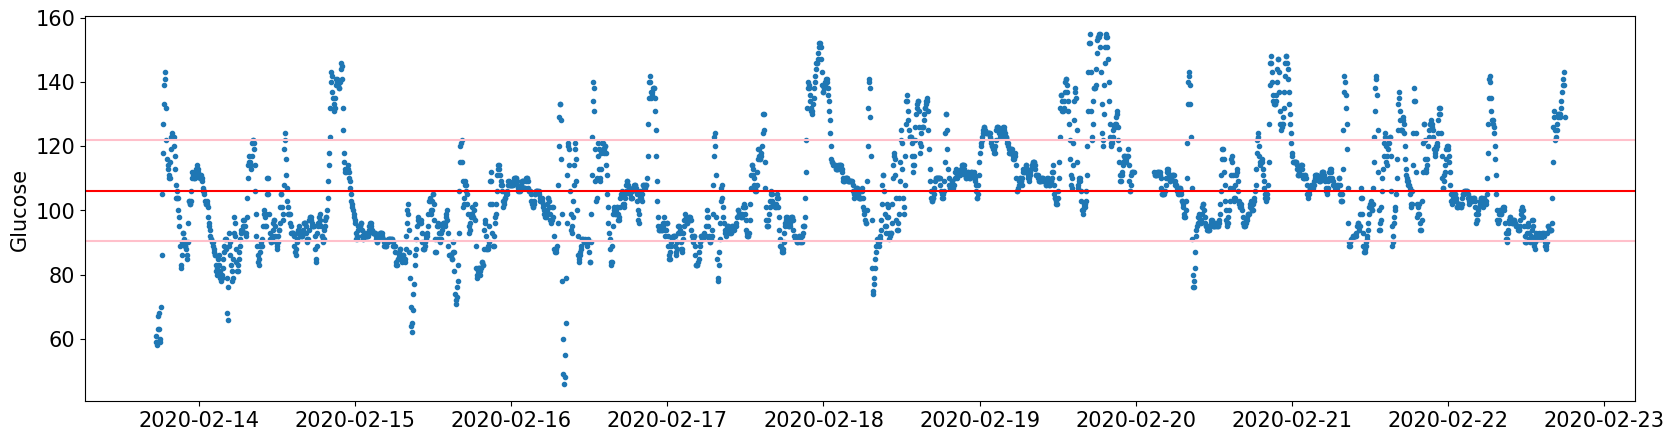

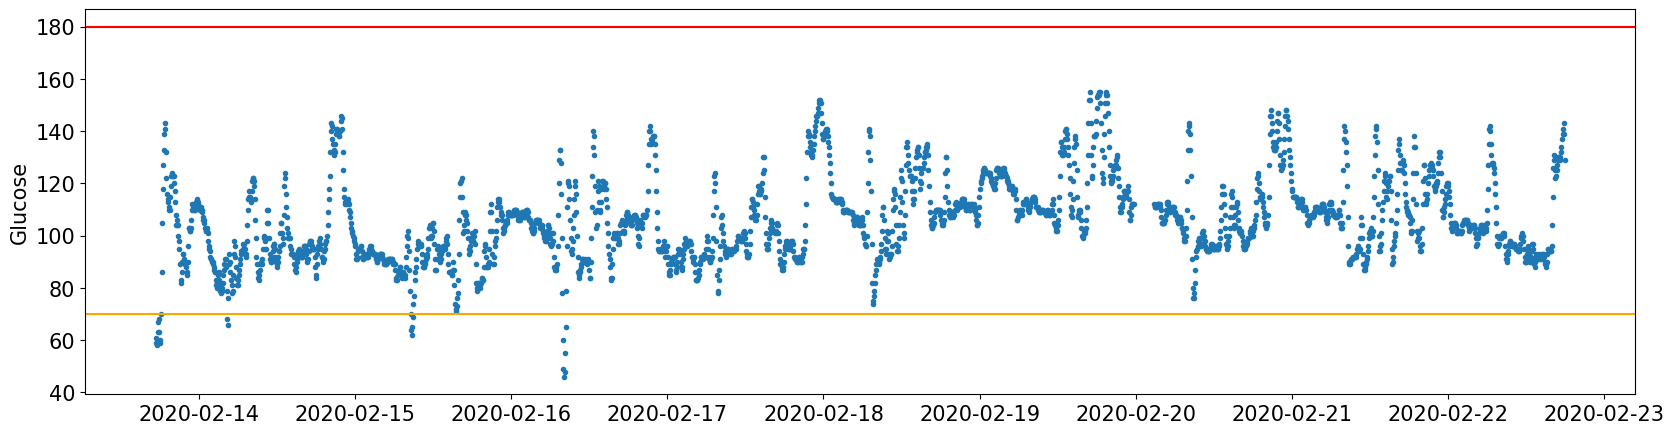

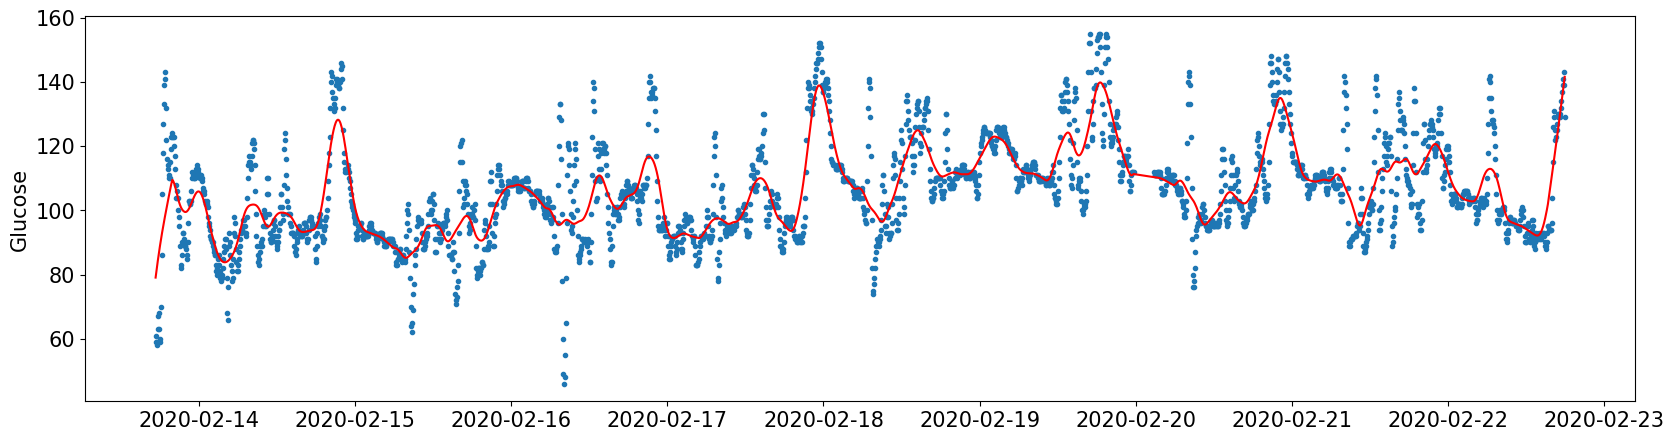

dex.interdaycv():  14.862268235481096
dex.interdaysd():  15.767932265480777
dex.intradaycv():  (13.504458156207187, 13.30496101353044, 2.9522462166748786)
dex.intradaysd():  (14.209825037890358, 13.846072908212498, 2.8160636612639594)
dex.TIR():  9080
dex.TOR():  3725
dex.POR():  29.09019914096056
dex.PIR():  70.90980085903944
dex.MGE():  index      1213.236242
Glucose     111.668456
dtype: float64
dex.MGN():  index      1324.312225
Glucose     103.806718
dtype: float64
dex.MAGE():  52.781
dex.J_index():  14.850260682643281
dex.BGI():  0      -0.751814
1      -0.792493
2      -0.813342
3      -0.792493
4      -0.712421
          ...   
2556    0.261520
2557    0.279230
2558    0.296695
2559    0.261520
2560    0.169033
Name: Glucose, Length: 2561, dtype: float64
dex.LBGI():  0.7476210929483644
dex.HBGI():  0.18210941446257198
dex.LBGI_HBGI():  (0.7476210929483644,)
dex.ADRR():  30.9006360630576
dex.MODD():  15.369130843826893
dex.CONGA24():  7.5744275171736914
dex.GMI():  5.84776162436

In [132]:
# Class Component Time: ~4.94s

import time

start = time.time()
#_______________________________________________________________________________________

n = 1
typ = 'Dexcom'
file_path = "physio/files/big-ideas-glycemic-wearable/1.0.0/"
file = file_path+"00{n}/{typ}_00{n}.csv".format(n=n,typ=typ)
dex = CGM_Quant(file)

functions = ['interdaycv', 'interdaysd', 'intradaycv', 'intradaysd', 'TIR', 'TOR', \
             'POR', 'PIR', 'MGE', 'MGN', 'MAGE', 'J_index', 'BGI', 'LBGI', 'HBGI', \
             'LBGI_HBGI', 'ADRR', 'MODD', 'CONGA24', 'GMI', 'eA1C', 'summary', \
             'plotglucosesd', 'plotglucosebounds', 'plotglucosesmooth']

func, ind = np.unique(["dex."+f+'(): ' for f in functions], return_index=True)
func = func[np.argsort(ind)]
res = [dex.interdaycv(), dex.interdaysd(), dex.intradaycv(), dex.intradaysd(), dex.TIR(), dex.TOR(), \
 dex.POR(), dex.PIR(), dex.MGE(), dex.MGN(), dex.MAGE(), dex.J_index(), \
 dex.BGI(), dex.LBGI()[0], dex.HBGI()[0], dex.LBGI_HBGI()[0:1], dex.ADRR(), \
 dex.MODD(), dex.CONGA24(), dex.GMI(), dex.eA1c(), dex.summary(), dex.plotglucosesd(), \
 dex.plotglucosebounds(), dex.plotglucosesmooth()]

for i in range(len(func)):
    print(func[i], res[i])

#_______________________________________________________________________________________

end = time.time()
print(end - start)

# Original CGM Quantify and Runtime:

In [135]:
import pandas as pd
import datetime as datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

def importdexcom(filename):
    """
        Imports data from Dexcom continuous glucose monitor devices
        Args:
            filename (String): path to file
        Returns:
            (pd.DataFrame): dataframe of data with Time, Glucose, and Day columns
    """
    data = pd.read_csv(filename) 
    df = pd.DataFrame()
    df['Time'] = data['Timestamp (YYYY-MM-DDThh:mm:ss)']
    df['Glucose'] = pd.to_numeric(data['Glucose Value (mg/dL)'])
    df.drop(df.index[:12], inplace=True)
    df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%dT%H:%M:%S')
    df['Day'] = df['Time'].dt.date
    df = df.reset_index()
    return df

def interdaycv(df):
    """
        Computes and returns the interday coefficient of variation of glucose
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            cvx (float): interday coefficient of variation averaged over all days
            
    """
    cvx = (np.std(df['Glucose']) / (np.mean(df['Glucose'])))*100
    return cvx

def interdaysd(df):
    """
        Computes and returns the interday standard deviation of glucose
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            interdaysd (float): interday standard deviation averaged over all days
            
    """
    interdaysd = np.std(df['Glucose'])
    return interdaysd

def intradaycv(df):
    """
        Computes and returns the intraday coefficient of variation of glucose 
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            intradaycv_mean (float): intraday coefficient of variation averaged over all days
            intradaycv_medan (float): intraday coefficient of variation median over all days
            intradaycv_sd (float): intraday coefficient of variation standard deviation over all days
            
    """
    intradaycv = []
    for i in pd.unique(df['Day']):
        intradaycv.append(interdaycv(df[df['Day']==i]))
    
    intradaycv_mean = np.mean(intradaycv)
    intradaycv_median = np.median(intradaycv)
    intradaycv_sd = np.std(intradaycv)
    
    return intradaycv_mean, intradaycv_median, intradaycv_sd


def intradaysd(df):
    """
        Computes and returns the intraday standard deviation of glucose 
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            intradaysd_mean (float): intraday standard deviation averaged over all days
            intradaysd_medan (float): intraday standard deviation median over all days
            intradaysd_sd (float): intraday standard deviation standard deviation over all days
            
    """
    intradaysd =[]

    for i in pd.unique(df['Day']):
        intradaysd.append(np.std(df[df['Day']==i])['Glucose']) # <--- *** BUG HERE! *** --->
                                                               # Original is missing ['Glucose']
    
    intradaysd_mean = np.mean(intradaysd)
    intradaysd_median = np.median(intradaysd)
    intradaysd_sd = np.std(intradaysd)
    return intradaysd_mean, intradaysd_median, intradaysd_sd

def TIR(df, sd=1, sr=5):
    """
        Computes and returns the time in range
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
            sr (integer): sampling rate (default=5[minutes, once every 5 minutes glucose is recorded])
        Returns:
            TIR (float): time in range, units=minutes
            
    """
    up = np.mean(df['Glucose']) + sd*np.std(df['Glucose'])
    dw = np.mean(df['Glucose']) - sd*np.std(df['Glucose'])
    TIR = len(df[(df['Glucose']<= up) & (df['Glucose']>= dw)])*sr 
    return TIR

def TOR(df, sd=1, sr=5):
    """
        Computes and returns the time outside range
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing  range (default=1)
            sr (integer): sampling rate (default=5[minutes, once every 5 minutes glucose is recorded])
        Returns:
            TOR (float): time outside range, units=minutes
            
    """
    up = np.mean(df['Glucose']) + sd*np.std(df['Glucose'])
    dw = np.mean(df['Glucose']) - sd*np.std(df['Glucose'])
    TOR = len(df[(df['Glucose']>= up) | (df['Glucose']<= dw)])*sr
    return TOR

def POR(df, sd=1, sr=5):
    """
        Computes and returns the percent time outside range
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
            sr (integer): sampling rate (default=5[minutes, once every 5 minutes glucose is recorded])
        Returns:
            POR (float): percent time outside range, units=%
            
    """
    up = np.mean(df['Glucose']) + sd*np.std(df['Glucose'])
    dw = np.mean(df['Glucose']) - sd*np.std(df['Glucose'])
    TOR = len(df[(df['Glucose']>= up) | (df['Glucose']<= dw)])*sr
    POR = (TOR/(len(df)*sr))*100
    return POR

def PIR(df, sd=1, sr=5):
    """
        Computes and returns the percent time inside range
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
            sr (integer): sampling rate (default=5[minutes, once every 5 minutes glucose is recorded])
        Returns:
            PIR (float): percent time inside range, units=%
            
    """
    up = np.mean(df['Glucose']) + sd*np.std(df['Glucose'])
    dw = np.mean(df['Glucose']) - sd*np.std(df['Glucose'])
    TIR = len(df[(df['Glucose']<= up) | (df['Glucose']>= dw)])*sr
    PIR = (TIR/(len(df)*sr))*100
    return PIR

def MGE(df, sd=1):
    """
        Computes and returns the mean of glucose outside specified range
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
        Returns:
            MGE (float): the mean of glucose excursions (outside specified range)
            
    """
    up = np.mean(df['Glucose']) + sd*np.std(df['Glucose'])
    dw = np.mean(df['Glucose']) - sd*np.std(df['Glucose'])
    MGE = np.mean(df[(df['Glucose']>= up) | (df['Glucose']<= dw)])
    return MGE

def MGN(df, sd=1):
    """
        Computes and returns the mean of glucose inside specified range
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
        Returns:
            MGN (float): the mean of glucose excursions (inside specified range)
            
    """
    up = np.mean(df['Glucose']) + sd*np.std(df['Glucose'])
    dw = np.mean(df['Glucose']) - sd*np.std(df['Glucose'])
    MGN = np.mean(df[(df['Glucose']<= up) & (df['Glucose']>= dw)])
    return MGN

def MAGE(df, std=1):
    """
        Computes and returns the mean amplitude of glucose excursions
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
        Returns:
            MAGE (float): the mean amplitude of glucose excursions 
        Refs:
            Sneh Gajiwala: https://github.com/snehG0205/NCSA_genomics/tree/2bfbb87c9c872b1458ef3597d9fb2e56ac13ad64
            
    """
        
    #extracting glucose values and incdices
    glucose = df['Glucose'].tolist()
    ix = [1*i for i in range(len(glucose))]
    stdev = std

    # local minima & maxima
    a = np.diff(np.sign(np.diff(glucose))).nonzero()[0] + 1
    # local min
    valleys = (np.diff(np.sign(np.diff(glucose))) > 0).nonzero()[0] + 1
    # local max
    peaks = (np.diff(np.sign(np.diff(glucose))) < 0).nonzero()[0] + 1
    # +1 -- diff reduces original index number

    #store local minima and maxima -> identify + remove turning points
    excursion_points = pd.DataFrame(columns=['Index', 'Time', 'Glucose', 'Type'])
    k=0
    for i in range(len(peaks)):
        excursion_points.loc[k] = [peaks[i]] + [df['Time'][k]] + [df['Glucose'][k]] + ["P"]
        k+=1

    for i in range(len(valleys)):
        excursion_points.loc[k] = [valleys[i]] + [df['Time'][k]] + [df['Glucose'][k]] + ["V"]
        k+=1

    excursion_points = excursion_points.sort_values(by=['Index'])
    excursion_points = excursion_points.reset_index(drop=True)


    # selecting turning points
    turning_points = pd.DataFrame(columns=['Index', 'Time', 'Glucose', 'Type'])
    k=0
    for i in range(stdev,len(excursion_points.Index)-stdev):
        positions = [i-stdev,i,i+stdev]
        for j in range(0,len(positions)-1):
            if(excursion_points.Type[positions[j]] == excursion_points.Type[positions[j+1]]):
                if(excursion_points.Type[positions[j]]=='P'):
                    if excursion_points.Glucose[positions[j]]>=excursion_points.Glucose[positions[j+1]]:
                        turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                        k+=1
                    else:
                        turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                        k+=1
                else:
                    if excursion_points.Glucose[positions[j]]<=excursion_points.Glucose[positions[j+1]]:
                        turning_points.loc[k] = excursion_points.loc[positions[j]]
                        k+=1
                    else:
                        turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                        k+=1

    if len(turning_points.index)<10:
        turning_points = excursion_points.copy()
        excursion_count = len(excursion_points.index)
    else:
        excursion_count = len(excursion_points.index)/2


    turning_points = turning_points.drop_duplicates(subset= "Index", keep= "first")
    turning_points=turning_points.reset_index(drop=True)
    excursion_points = excursion_points[excursion_points.Index.isin(turning_points.Index) == False]
    excursion_points = excursion_points.reset_index(drop=True)

    # calculating MAGE
    mage = turning_points.Glucose.sum()/excursion_count

    return round(mage,3)



def J_index(df):
    """
        Computes and returns the J-index
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            J (float): J-index of glucose
            
    """
    J = 0.001*((np.mean(df['Glucose'])+np.std(df['Glucose']))**2)
    return J

def LBGI_HBGI(df):
    """
        Connecter function to calculate rh and rl, used for ADRR function
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            LBGI (float): Low blood glucose index
            HBGI (float): High blood glucose index
            rl (float): See calculation of LBGI
            rh (float): See calculation of HBGI
            
    """
    f = ((np.log(df['Glucose'])**1.084) - 5.381)
    rl = []
    for i in f: 
        if (i <= 0):
            rl.append(22.77*(i**2))
        else:
            rl.append(0)

    LBGI = np.mean(rl)

    rh = []
    for i in f: 
        if (i > 0):
            rh.append(22.77*(i**2))
        else:
            rh.append(0)

    HBGI = np.mean(rh)
    
    return LBGI, HBGI, rh, rl



def LBGI(df):
    """
        Computes and returns the low blood glucose index
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            LBGI (float): Low blood glucose index
            
    """
    f = ((np.log(df['Glucose'])**1.084) - 5.381)
    rl = []
    for i in f: 
        if (i <= 0):
            rl.append(22.77*(i**2))
        else:
            rl.append(0)

    LBGI = np.mean(rl)
    return LBGI

def HBGI(df):
    """
        Computes and returns the high blood glucose index
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            HBGI (float): High blood glucose index
            
    """
    f = ((np.log(df['Glucose'])**1.084) - 5.381)
    rh = []
    for i in f: 
        if (i > 0):
            rh.append(22.77*(i**2))
        else:
            rh.append(0)

    HBGI = np.mean(rh)
    return HBGI

def ADRR(df):
    """
        Computes and returns the average daily risk range, an assessment of total daily glucose variations within risk space
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            ADRRx (float): average daily risk range
            
    """
    ADRRl = []
    for i in pd.unique(df['Day']):
        LBGI, HBGI, rh, rl = LBGI_HBGI(df[df['Day']==i])
        LR = np.max(rl)
        HR = np.max(rh)
        ADRRl.append(LR+HR)

    ADRRx = np.mean(ADRRl)
    return ADRRx

def uniquevalfilter(df, value):
    """
        Supporting function for MODD and CONGA24 functions
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            value (datetime): time to match up with previous 24 hours
        Returns:
            MODD_n (float): Best matched with unique value, value
            
    """
    xdf = df[df['Minfrommid'] == value]
    n = len(xdf)
    diff = abs(xdf['Glucose'].diff())
    MODD_n = np.nanmean(diff)
    return MODD_n

def MODD(df):
    """
        Computes and returns the mean of daily differences. Examines mean of value + value 24 hours before
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Requires:
            uniquevalfilter (function)
        Returns:
            MODD (float): Mean of daily differences
            
    """
    df['Timefrommidnight'] =  df['Time'].dt.time
    lists=[]
    for i in range(0, len(df['Timefrommidnight'])):
        lists.append(int(df['Timefrommidnight'][i].strftime('%H:%M:%S')[0:2])*60 + int(df['Timefrommidnight'][i].strftime('%H:%M:%S')[3:5]) + round(int(df['Timefrommidnight'][i].strftime('%H:%M:%S')[6:9])/60))
    df['Minfrommid'] = lists
    df = df.drop(columns=['Timefrommidnight'])
    
    #Calculation of MODD and CONGA:
    MODD_n = []
    uniquetimes = df['Minfrommid'].unique()

    for i in uniquetimes:
        MODD_n.append(uniquevalfilter(df, i))
    
    #Remove zeros from dataframe for calculation (in case there are random unique values that result in a mean of 0)
    MODD_n[MODD_n == 0] = np.nan
    
    MODD = np.nanmean(MODD_n)
    return MODD

def CONGA24(df):
    """
        Computes and returns the continuous overall net glycemic action over 24 hours
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Requires:
            uniquevalfilter (function)
        Returns:
            CONGA24 (float): continuous overall net glycemic action over 24 hours
            
    """
    df['Timefrommidnight'] =  df['Time'].dt.time
    lists=[]
    for i in range(0, len(df['Timefrommidnight'])):
        lists.append(int(df['Timefrommidnight'][i].strftime('%H:%M:%S')[0:2])*60 + int(df['Timefrommidnight'][i].strftime('%H:%M:%S')[3:5]) + round(int(df['Timefrommidnight'][i].strftime('%H:%M:%S')[6:9])/60))
    df['Minfrommid'] = lists
    df = df.drop(columns=['Timefrommidnight'])
    
    #Calculation of MODD and CONGA:
    MODD_n = []
    uniquetimes = df['Minfrommid'].unique()

    for i in uniquetimes:
        MODD_n.append(uniquevalfilter(df, i))
    
    #Remove zeros from dataframe for calculation (in case there are random unique values that result in a mean of 0)
    MODD_n[MODD_n == 0] = np.nan
    
    CONGA24 = np.nanstd(MODD_n)
    return CONGA24

def GMI(df):
    """
        Computes and returns the glucose management index
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            GMI (float): glucose management index (an estimate of HbA1c)
            
    """
    GMI = 3.31 + (0.02392*np.mean(df['Glucose']))
    return GMI

def eA1c(df):
    """
        Computes and returns the American Diabetes Association estimated HbA1c
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            eA1c (float): an estimate of HbA1c from the American Diabetes Association
            
    """
    eA1c = (46.7 + np.mean(df['Glucose']))/ 28.7 
    return eA1c

def summary(df): 
    """
        Computes and returns glucose summary metrics
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            meanG (float): interday mean of glucose
            medianG (float): interday median of glucose
            minG (float): interday minimum of glucose
            maxG (float): interday maximum of glucose
            Q1G (float): interday first quartile of glucose
            Q3G (float): interday third quartile of glucose
            
    """
    meanG = np.nanmean(df['Glucose'])
    medianG = np.nanmedian(df['Glucose'])
    minG = np.nanmin(df['Glucose'])
    maxG = np.nanmax(df['Glucose'])
    Q1G = np.nanpercentile(df['Glucose'], 25)
    Q3G = np.nanpercentile(df['Glucose'], 75)
    
    return meanG, medianG, minG, maxG, Q1G, Q3G

def plotglucosesd(df, sd=1, size=15):
    """
        Plots glucose with specified standard deviation lines
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation lines to plot (default=1)
            size (integer): font size for plot (default=15)
        Returns:
            plot of glucose with standard deviation lines
            
    """
    glucose_mean = np.mean(df['Glucose'])
    up = np.mean(df['Glucose']) + sd*np.std(df['Glucose'])
    dw = np.mean(df['Glucose']) - sd*np.std(df['Glucose'])

    plt.figure(figsize=(20,5))
    plt.rcParams.update({'font.size': size})
    plt.plot(df['Time'], df['Glucose'], '.', color = '#1f77b4')
    plt.axhline(y=glucose_mean, color='red', linestyle='-')
    plt.axhline(y=up, color='pink', linestyle='-')
    plt.axhline(y=dw, color='pink', linestyle='-')
    plt.ylabel('Glucose')
    plt.show()

def plotglucosebounds(df, upperbound = 180, lowerbound = 70, size=15):
    """
        Plots glucose with user-defined boundaries
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            upperbound (integer): user defined upper bound for glucose line to plot (default=180)
            lowerbound (integer): user defined lower bound for glucose line to plot (default=70)
            size (integer): font size for plot (default=15)
        Returns:
            plot of glucose with user defined boundary lines
            
    """
    plt.figure(figsize=(20,5))
    plt.rcParams.update({'font.size': size})
    plt.plot(df['Time'], df['Glucose'], '.', color = '#1f77b4')
    plt.axhline(y=upperbound, color='red', linestyle='-')
    plt.axhline(y=lowerbound, color='orange', linestyle='-')
    plt.ylabel('Glucose')
    plt.show()

def plotglucosesmooth(df, size=15):
    """
        Plots smoothed glucose plot (with LOWESS smoothing)
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            size (integer): font size for plot (default=15)
        Returns:
            LOWESS-smoothed plot of glucose
            
    """
    filteres = lowess(df['Glucose'], df['Time'], is_sorted=True, frac=0.025, it=0)
    filtered = pd.to_datetime(filteres[:,0], format='%Y-%m-%dT%H:%M:%S') 
    
    plt.figure(figsize=(20,5))
    plt.rcParams.update({'font.size': size})
    plt.plot(df['Time'], df['Glucose'], '.')
    plt.plot(filtered, filteres[:,1], 'r')
    plt.ylabel('Glucose')
    plt.show()


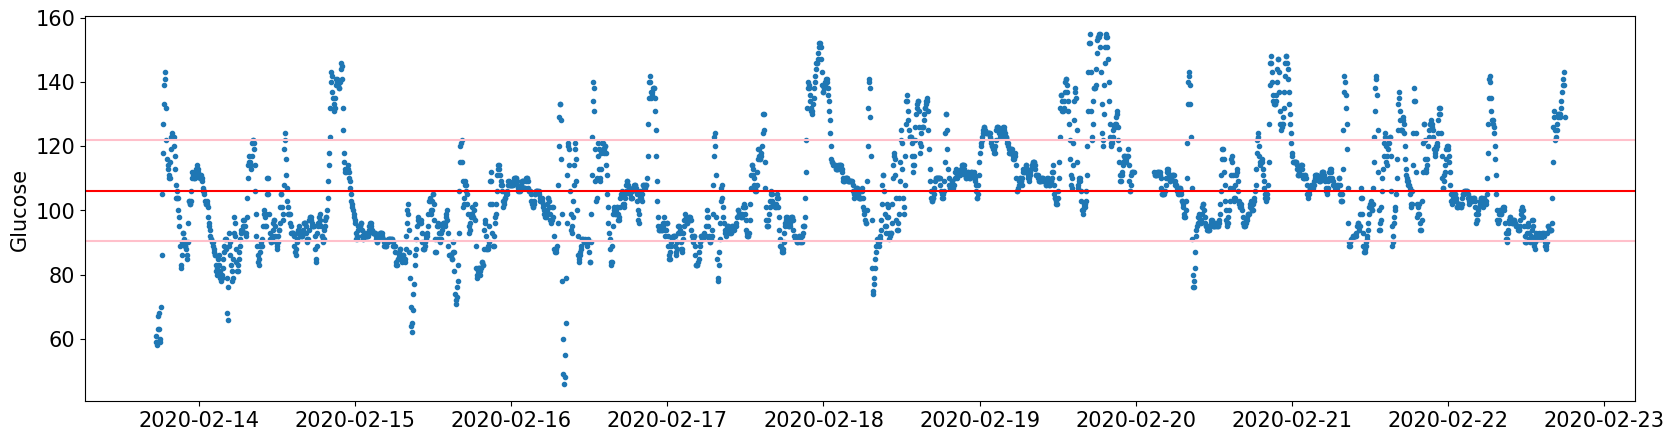

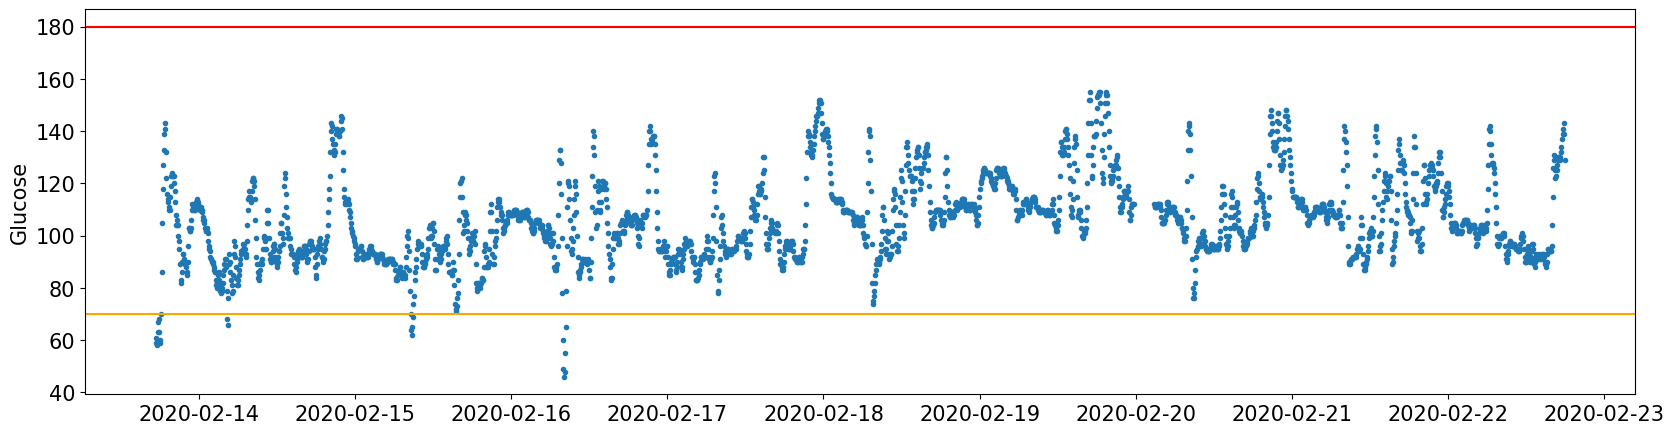

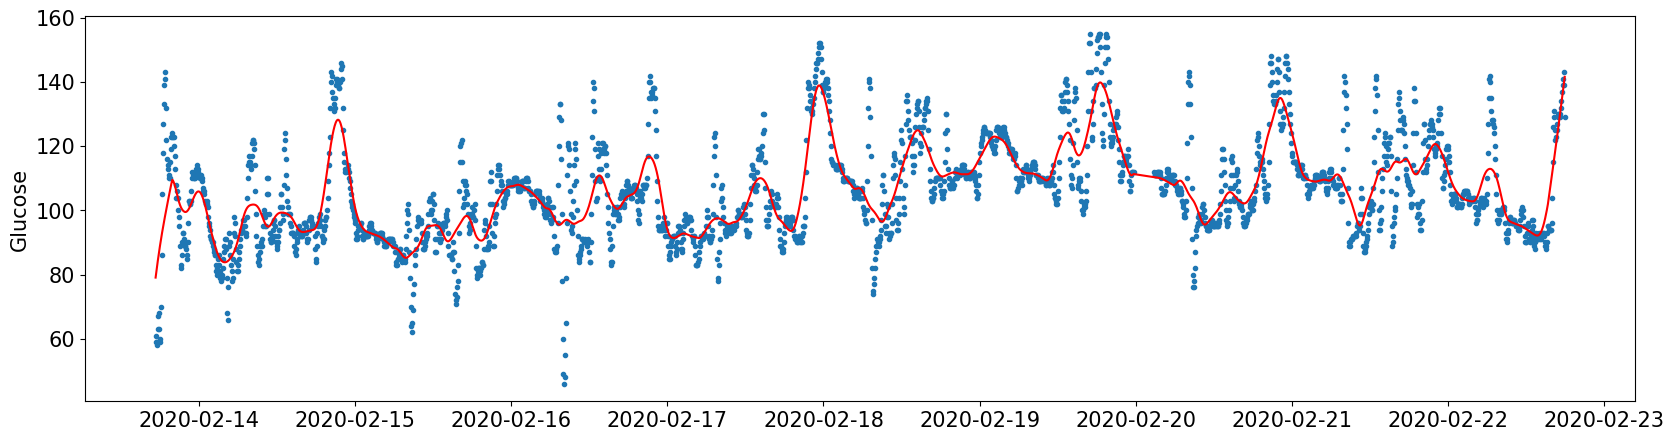

dex.interdaycv():  14.862268235481096
dex.interdaysd():  15.767932265480777
dex.intradaycv():  (13.504458156207187, 13.30496101353044, 2.9522462166748786)
dex.TIR():  (14.209825037890358, 13.846072908212498, 2.8160636612639594)
dex.TOR():  9080
dex.POR():  3725
dex.PIR():  29.09019914096056
dex.MGE():  100.0
dex.MGN():  index      1213.236242
Glucose     111.668456
dtype: float64
dex.MAGE():  index      1324.312225
Glucose     103.806718
dtype: float64
dex.J_index():  52.781
dex.BGI():  14.850260682643281
dex.LBGI_HBGI():  (0.7476210929483644, 0.18210941446257198, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07867742880762499, 0.5102223634691586, 0.9742187518481885, 1.5572995646356516, 2.0043953161114096, 1.7753630818731316, 0.8881578099097578, 0.22769487670991972, 0.032286919417721355, 0.00595277170029379, 0.0006362510959979114, 0, 0, 0, 0.016547956609727764, 0.10907952432077343, 0.2759962077618669, 0.2759962077618669, 0.3285005118167726, 0.2759962077618669, 0.2759962077618669, 0.1441261

In [136]:
# WITHOUT Class Component Time: ~6.76s

import time

start = time.time()
#_______________________________________________________________________________________

n = 1
typ = 'Dexcom'
file_path = "physio/files/big-ideas-glycemic-wearable/1.0.0/"
file = file_path+"00{n}/{typ}_00{n}.csv".format(n=n,typ=typ)

df = importdexcom(file)

functions = ['interdaycv', 'interdaysd', 'intradaycv', 'TIR', 'TOR', 'POR', 'PIR', \
             'MGE', 'MGN', 'MAGE', 'J_index', 'BGI', 'LBGI_HBGI', 'LBGI', 'HBGI', \
             'ADRR', 'MODD', 'CONGA24', 'GMI', 'eA1C', 'summary']

func, ind = np.unique(["dex."+f+'(): ' for f in functions], return_index=True)
func = func[np.argsort(ind)]

res = [interdaycv(df), interdaysd(df), intradaycv(df), intradaysd(df), \
TIR(df, sd=1, sr=5), TOR(df, sd=1, sr=5), POR(df, sd=1, sr=5), PIR(df, sd=1, sr=5), \
MGE(df, sd=1), MGN(df, sd=1), MAGE(df, std=1), J_index(df), LBGI_HBGI(df), LBGI(df), \
HBGI(df), ADRR(df), MODD(df), CONGA24(df), GMI(df), eA1c(df), summary(df), \
plotglucosesd(df, sd=1, size=15), \
plotglucosebounds(df, upperbound = 180, lowerbound = 70, size=15), \
plotglucosesmooth(df, size=15)]

for i in range(len(func)):
    print(func[i], res[i])
    

#_______________________________________________________________________________________

end = time.time()
print(end - start)